In [1]:
import re
import requests
import json
import os
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import matplotlib.pyplot as plt

from operator import itemgetter
from nltk import tokenize, sent_tokenize, RegexpTokenizer, ngrams
from sklearn.decomposition import PCA
from scipy.sparse import hstack
# from wordcloud import WordCloud, ImageColorGenerator
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, normalize, Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
def liwc_analysis(text):
    X_API_SECRET_KEY = 'tg3OK1kcQdU8RXjx2ghyjNcB6vmg82nYALAS3ImVBYg'
    X_API_KEY = '584055def86167059a1c1d34'

    header = {}
    header['X-API-KEY'] = X_API_KEY
    header['X-API-SECRET-KEY'] = X_API_SECRET_KEY
    header['Content-type'] = 'application/json'

    url = 'https://api-v3.receptiviti.com/v3/api/content'
    
    
    payload = {"content_source": 0,
                              "language_content": text
          }
    try:    
        r = requests.post(url, headers=header, json=payload, timeout=45)
        json_to_dump = json.loads(r.text)
        return json_to_dump['liwc_scores']['categories']

    except Exception as e:
        print("error")
        pass


def create_liwc_df(text,temp):
    for i in range(1,len(text)):
        print(text[i])
        text = liwc_analysis(text[i])
        temp_obj = pd.DataFrame(data=text, index=[i])
        temp = pd.concat((temp, temp_obj), axis=0)
    return temp

In [3]:
def generate_wordcloud(text,title,max_words = 50):
    words = text['post_text'].str.cat()
    
    wordcloud = WordCloud(max_words=max_words,background_color='white', max_font_size=50).generate(words)

    # Display the generated image:
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def generate_CDF(data):

    temp_depression = data['num_words_post'].value_counts().sort_index()
    temp_depression /= np.sum(temp_depression.values)
    depression_indice_list = temp_depression.index
    temp_depression = temp_depression.reset_index().drop('index',axis=1)
    CDF_depression = np.zeros(len(temp_depression))
    CDF_depression[0] = temp_depression.iloc[0,0]


    for i in range(1, len(temp_depression)):
        CDF_depression[i] = CDF_depression[i-1] + temp_depression.iloc[i,0]
    return CDF_depression, depression_indice_list

    
    
def vector_transformers(text_column):

    count_vect = CountVectorizer()
    post_text = count_vect.fit_transform(text_column)

    tfidf_transformer = TfidfTransformer()
    post_text_tfidf = tfidf_transformer.fit_transform(post_text)

    return post_text_tfidf


# Clean dataset
def clean_data(dataset):
#     dataset = dataset[dataset['subreddit'] != 'depression']
#     dataset = dataset[dataset['subreddit'] != 'AskReddit']
    dataset['post_text'] = dataset['post_text'].fillna('')
    dataset              = dataset[dataset['post_text'] != '[removed]']
    dataset['post_text'] = dataset['post_text'].str.replace('\r', '')#.apply(lambda x: x.replace('\r', ''))
    dataset['post_text'] = dataset['post_text'].str.replace("\n", "")#.apply(lambda x: x.replace('\n', ''))
    dataset['post_text'] = dataset['post_text'].str.replace("\'", "")#.apply(lambda x: x.replace("\'", ""))
    dataset = dataset.dropna().reset_index()

    return dataset

def post_to_wordlist(post, remove_stopwords=True, split=False):
    
    post = re.sub("[^a-zA-Z]"," ", post)
    words = post.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if split:
        return words
    else:
        return (' '.join(words))

In [4]:
# Load the data and clean it.
# if you have internet connection use the markdown below instead of this code block
# use this one only if you have the data file saved on your machine

df = pd.read_csv('https://raw.githubusercontent.com/GiladGecht/DepressionResearch/master/depression_neutral_df.csv')
df = shuffle(df)
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df.dropna()


target = '_subreddit'
cols = '_title'

X = df[cols]
y = df[target]

count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

print("Accuracy Score:",score)
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
print("AUC Score:", np.mean(cross_val_score(svc, X_test, y_test, cv=10, scoring='roc_auc')))


Accuracy Score: 0.8746713409290097
[[1789  200]
 [ 229 1205]]
AUC Score: 0.8977064777958452


In [5]:
cm_holder = []
kf = KFold(n_splits=5, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    svc.fit(X_train, y_train)
    cm_holder.append(confusion_matrix(y_test, svc.predict(X_test)))

In [6]:
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['reddit' 'redditors' 'movie' 'askreddit' 'dirty' 'snack' 'hype' 'secret'
 'actuslly' 'resolution']

Largest Coefs: 
['depression' 'depressed' 'suicidal' 'suicide' 'feels' 'sad' 'therapist'
 'bed' 'rant' 'depressive']



In [7]:
# Load main dataset and clean it by removing deleted posts and filling presumed posts with pictures with ''
# Apply the trained LinearSVC classifier on the dataset
whole_data = pd.read_csv(r'C:\Users\Gilad Gecht\DepressionResearch\DepressionResearch\Data\SubmissionsDF.csv',index_col=0)
whole_data = whole_data.drop(['appearance', 'text_changed'], axis=1)
whole_data = clean_data(whole_data)
whole_data['predicted'] = svc.predict(count_vect.transform(whole_data['title']))
whole_data.shape

(460810, 16)

In [8]:
# for the top n common subreddits (probably depression related)
# plot the distribution of predicted neutral posts vs depression posts 
# i.e. subreddit = 'depression', num_posts = 3000, predicted_1 = 2500 (depression), predicted_0 


N = whole_data.shape[0]
most_common_subreddits = list(whole_data['subreddit'].value_counts().nlargest(N).keys())
most_common_subreddits = whole_data[whole_data['subreddit'].isin(most_common_subreddits)]

temp = most_common_subreddits['subreddit'].value_counts()
sum_subreddit_dict = temp.to_dict()

temp = most_common_subreddits.groupby(['subreddit','predicted'], as_index=False).agg({"submission_id":"count"})
temp['appearance'] = temp['subreddit'].apply(lambda x: sum_subreddit_dict[x])
temp['submission_id'] /= temp['appearance']

pred_depression = temp.iloc[1::2,:]
pred_neutral = temp.iloc[::2,:]

ind = np.arange(N)
width = .35
# plt.figure(figsize=(20,8))
# p1 = plt.bar(ind, pred_depression['submission_id'], width, edgecolor='k', label='depression')
# p2 = plt.bar(ind, pred_neutral['submission_id'], width, edgecolor='k', label='neutral',bottom=pred_depression['submission_id'])


# plt.title("Distribution of predicted values for N most common subreddits", size=15)
# plt.ylabel('Percentile',size=15)
# plt.xlabel('Subreddit', size=15)
# plt.xticks(ind, list(pred_depression['subreddit'].values))
# plt.legend()
# plt.grid()
# plt.show()


In [65]:
N = whole_data.shape[0]
most_common_subreddits = list(whole_data['subreddit'].value_counts().nlargest(N).keys())
most_common_subreddits = whole_data[whole_data['subreddit'].isin(most_common_subreddits)]

temp = most_common_subreddits['subreddit'].value_counts() 
sum_subreddit_dict = temp.to_dict()
temp = most_common_subreddits.groupby(['subreddit','predicted'], as_index=False).agg({"submission_id":"count"})


In [66]:
def get_percentage(subreddit, count):
    global sum_subreddit_dict
    return count / sum_subreddit_dict[subreddit]

temp['percentage'] = temp.apply(lambda x: get_percentage(x.subreddit, x.submission_id), axis=1)

In [67]:
# temp = temp[(temp['percentage'] > 0.3) & (temp['percentage'] < 0.7)]

temp = temp[temp['percentage'] >= 0.7]

In [68]:
temp['predicted'] = temp['predicted'].replace({0: "Neutral", 1: "Depression"})

In [69]:
temp.drop('submission_id', axis=1).to_csv('filtered_subreddits.csv', index=False)

In [70]:
temp

,subreddit,predicted,submission_id,percentage
9,2meirl42meirl4meirl,Depression,50,0.909091
11,2meirl4meirl,Depression,901,0.970905
12,3DS,Neutral,38,0.703704
16,40kLore,Neutral,50,0.746269
28,ACTrade,Neutral,52,0.764706
64,AmericanHorrorStory,Neutral,53,0.726027
66,Android,Neutral,45,0.833333
68,AndroidGaming,Neutral,41,0.820000
70,AndroidQuestions,Neutral,104,0.764706
82,Animesuggest,Neutral,113,0.729032


In [71]:
neutral_subreddits_x = pd.read_csv('neutral_subreddits.csv')
depression_subreddits_x = pd.read_csv('depression_subreddits.csv')

In [75]:
depression_subreddits_x = pd.merge(depression_subreddits_x, temp, left_on='subreddit', right_on='subreddit').sort_values(by='percentage', ascending=False)

In [77]:
depression_subreddits_x[['subreddit', 'predicted', 'percentage']].to_csv('depression_subreddits.csv', index=False)

In [78]:
neutral_subreddits_x = pd.merge(neutral_subreddits_x, temp, left_on='subreddit', right_on='subreddit').sort_values(by='percentage', ascending=False)

In [80]:
neutral_subreddits_x[['subreddit', 'predicted', 'percentage']].to_csv('neutral_subreddits.csv', index=False)

In [14]:
# Neutral - 0
# Depression - 1

In [15]:
# Distribution of predicted values
whole_data['predicted'].value_counts()

0    275693
1    185117
Name: predicted, dtype: int64

In [16]:
# Filter out the data by noise
# Subreddits with less than 50 appearences are dropped out 
counts = whole_data['subreddit'].value_counts()
popular_subreddits = counts[counts.values >= 50].keys()
whole_data = whole_data[(whole_data['subreddit'].isin(popular_subreddits))]

In [17]:
# Number of UNIQUE subreddits left after being filtered
subreddits = set(whole_data['subreddit'])
len(subreddits)

1176

In [18]:
# Apply a second filter,
# by checking the tendency of a certain subreddit to be either depression or neutral
# if its over 70% towards a certain side, append to the appropriate list

neutral_subreddits = []
depression_subreddits = []
for i in subreddits:
    values = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values
    sum_values = np.sum(whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values)
    values_perc = values/sum_values
    value1 = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values[0]
    if whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().keys()[0] == 0:
        if values_perc[0] >= 0.7:
            neutral_subreddits.append(i)
    else:
        if values_perc[0] >= 0.7:
            depression_subreddits.append(i)

In [19]:
# Distribution of depression subreddits 
whole_data[whole_data['subreddit'].isin(depression_subreddits)]['subreddit'].value_counts()

depression             21359
me_irl                  2061
SuicideWatch            2049
Anxiety                 1543
2meirl4meirl             928
cursedcomments           802
mentalhealth             729
selfharm                 651
cursedimages             578
bipolar                  538
blursedimages            530
relationships            486
hmmm                     471
lonely                   417
DoesAnybodyElse          415
UnsentLetters            400
BreakUps                 339
TIHI                     303
BPD                      298
MakeNewFriendsHere       270
Vent                     265
Needafriend              262
CircleofTrust            237
gonewild                 210
r4r                      187
dirtykikpals             179
meirl                    176
depression_help          156
anime_irl                152
leaves                   139
                       ...  
ChronicPain               89
antidepressants           79
GiftofGames               75
u_Inkspent    

In [63]:
pd.DataFrame(neutral_subreddits, columns=['subreddit']).to_csv('neutral_subreddits.csv', index=False)

In [61]:
pd.DataFrame(depression_subreddits, columns=['subreddit']).to_csv('depression_subreddits.csv', index=False)

In [20]:
print("The Filtered Neutral Subreddits Are:\n\n",neutral_subreddits)
print(20*"-")
print("The Filtered Depression Subreddits are:\n\n", depression_subreddits)

The Filtered Neutral Subreddits Are:

 ['SuggestALaptop', 'yugioh', 'polls', 'suggestmeabook', 'iphone', 'residentevil', 'CFB', 'retrogaming', 'Damnthatsinteresting', 'CanadaPublicServants', 'borrow', 'GalaxyS9', 'Disneyland', 'Entrepreneur', 'nier', 'AmericanHorrorStory', 'dadjokes', 'dataisbeautiful', 'darkjokes', 'Filmmakers', 'AskAnAmerican', 'netflix', 'MovieSuggestions', 'apple', 'SteamGameSwap', 'FiftyFifty', 'cscareerquestions', 'investing', 'translator', 'RedLetterMedia', 'food', 'comicbooks', 'nba', 'tipofmytongue', 'Gunners', 'thesims', 'history', 'Showerthoughts', 'HumansBeingBros', 'AskCulinary', 'askscience', 'halloween', 'shittyfoodporn', 'AndroidGaming', 'marvelstudios', 'DirtyWritingPrompts', 'Jokes', 'tea', 'KingdomHearts', 'findareddit', 'HistoryWhatIf', '40kLore', 'SmallYTChannel', 'blackmirror', 'Madden', '3DS', 'science', 'WWEGames', 'AnythingGoesNews', 'Libertarian', 'ask', 'AskHistorians', 'whatstheword', 'todayilearned', 'MensRights', 'cars', 'The3Million', 'No

In [21]:
# Filtered by hand depression-related subreddits
depression_subreddit_filtered_list = ['depression_help', 'lonely', 'SuicideWatch', 'depression',
                                      'selfharm', 'mentalhealth', 'offmychest', 'Anxiety',]

In [22]:
# Split the dataframe to neutral and depressed by the filtered subreddits
depression_df = whole_data[whole_data['subreddit'].isin(depression_subreddit_filtered_list)]
neutral_df = whole_data[whole_data['subreddit'].isin(neutral_subreddits)]

In [23]:
# Get the list of all unique users for each type of dataset
depression_names = list(set(depression_df['user_name']))
neutral_names = list(set(neutral_df['user_name']))

In [24]:
# Merge them back to a single dataframe
full_df = pd.concat([depression_df,neutral_df],axis=0)
full_df.shape

(157969, 16)

In [25]:
# Filter out people who havn't posted in both types of subreddits (Depression/Neutral) in the current dataset
both = []
for i in depression_names:
    if i in neutral_names:
        both.append(i)

In [26]:
full_df = full_df[full_df['user_name'].isin(both)]
full_df = full_df.sort_values(by=['user_name','date_created'],ascending=False)
full_df['num_distinct_words'] = full_df['post_text'].apply(lambda x: len(set(x.split())))

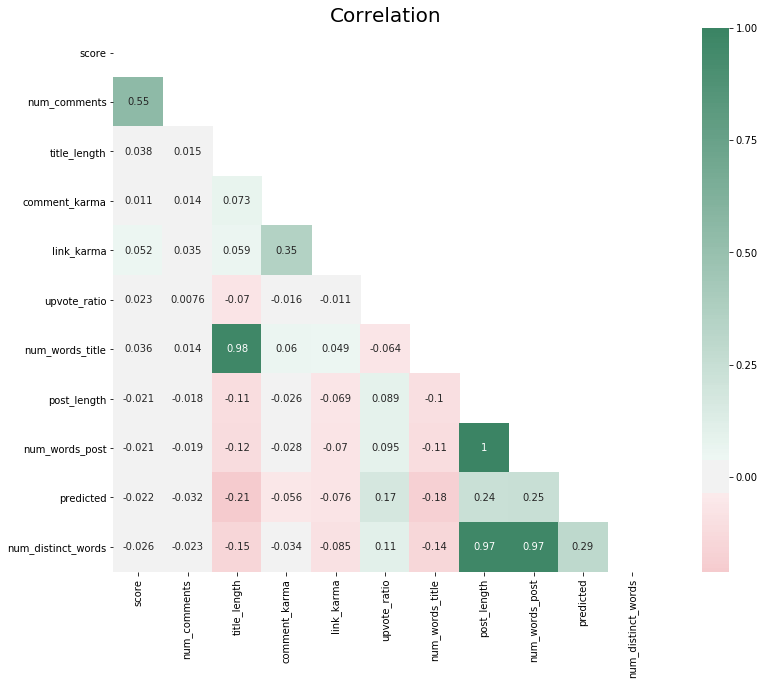

In [27]:
df_corr = full_df._get_numeric_data()

mask = np.zeros_like(df_corr.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sb.diverging_palette(10,150,as_cmap=True)

plt.figure(figsize=(16,10))
sb.heatmap(df_corr.corr(),cmap=cmap,annot=True,mask = mask,square = True,center = 0)
plt.title('Correlation',size=20)
plt.show()

In [28]:
# Create a colum comprised of tri-grams of the post's text
full_df['tokenized'] = full_df['post_text'].apply(lambda x: x.split())

blabla = []
for row in full_df['tokenized']: # Iterate over each row
    generated_3grams = []

    for word in row: # iterate over each word in the row
        generated_3grams.append(list(ngrams(word, 3, pad_left=True, pad_right=False, left_pad_symbol='_')))

    temp_bla = []
    for i in generated_3grams:# iterate over each list in the 3gram
        for j in i: # iterate over each tuple in the current list
            temp_bla.append(j)
    blabla.append(temp_bla)
    
full_df['trigrams'] = 0 
full_df = full_df.reset_index().drop('index',axis=1)

for i in range(len(full_df['trigrams'])):
    full_df['trigrams'][i] = blabla[i]
    
for i in range(len(full_df['trigrams'])):
    ng_list_3grams = full_df['trigrams'][i]
    for idx,val in enumerate(full_df['trigrams'][i]):
        ng_list_3grams[idx] = ''.join(val)
        
        
    full_df['trigrams'][i] = ng_list_3grams

full_df['trigrams'] = full_df['trigrams'].apply(lambda x: ' '.join(x))
full_df = full_df.drop('tokenized',axis=1)

ValueError: setting an array element with a sequence.

In [30]:
from liwc import Liwc

In [31]:
LIWC_TRAIN_DICT = {}
liwc = Liwc(r'LIWC2015_English_Flat.dic')
for sent in full_df['post_text']:
    LIWC_TRAIN_DICT[sent] = dict(liwc.parse(sent.split(' ')))

liwc_df = pd.DataFrame.from_dict(LIWC_TRAIN_DICT, orient='index').fillna(0)
liwc_df = liwc_df.reset_index()

In [32]:
full_liwc_df = pd.merge(full_df, liwc_df, left_on=['post_text'], right_on=['index'])

In [33]:
# Find by using regular expressions all the sentences
# which are built in the following way: "i ...... depress/ed/ion/ants and so on"

count = 0
sentences = []
post = []
subreddits = []
for row in full_df.iterrows():
    
    sentence = row[1]['post_text']
    bla = re.findall(r'\bi\s.*\bdepress[\w]*\b', sentence)
    if len(bla) > 0:
#         print(bla)
#         print("User:",row[1]['user_name'])
#         print("Subreddit:",row[1]['subreddit'])
#         print(10*'-')
        post.append(row[1]['submission_id'])
        subreddits.append(row[1]['subreddit'])
        sentences.append(sentence)
        count += 1
# print(count)

In [34]:
count = 0
for row in full_df.iterrows():

    sentence = row[1]['post_text']
    bla = re.findall("my[\w]*\s.*depress[\w]*",sentence)
    if len(bla) > 0:
#         print(bla)
#         print("User:",row[1]['user_name'])
#         print("Subreddit:",row[1]['subreddit'])
#         print(10*'-')
        count += 1
print(count)

2887


In [35]:
# Find out how many unique users we found who match our regular expressions - by submission id
# this is done to get only their depression related posts and not their entire posts
# Later on, we'll take the rest of their post and categorize them as neutral based
# this will be our compare group
users_filtered_by_re = list(set(post))
len(list(set(post)))

3354

In [36]:
# Get all the unique users found in the previous step
filtered_by_re = full_df[full_df['submission_id'].isin(users_filtered_by_re)].copy()

In [37]:
expressed_depression_users = filtered_by_re['user_name'].unique()

In [38]:
# Take n largest subreddit by appreance in the filtered dataset
# n_largest = list(filtered_by_re['subreddit'].value_counts().nlargest(9).keys())

In [39]:
# Create the final depressed testing group to be compared with neutral people
# by taking the depressed test group user id's, we can create the group's neutral posts
# depressed_group_depressed_posts = filtered_by_re[filtered_by_re['subreddit'].isin(n_largest)]
# depression_group_users          = depressed_group_depressed_posts['user_name'].unique()
# depression_group_users_indices  = list(set(depressed_group_depressed_posts['user_name'].index))

# Fine until here
Use the depression group users to find all of their posts who's subreddit is **NOT** classified as depression related

DEPRESSION: 1  
NEUTRAL: 0

In [40]:
# Depressed users, neutral posts
depression_group_users_full_posts = whole_data[whole_data['user_name'].isin(expressed_depression_users)]
# depressed_users_neutral_posts = depression_group_users_full_posts[depression_group_users_full_posts['predicted'] == 0]
depressed_users_neutral_posts = depression_group_users_full_posts[~(depression_group_users_full_posts['subreddit'].isin(depression_subreddits))]
depressed_users_neutral_posts = depressed_users_neutral_posts[depressed_users_neutral_posts['post_text'] != ''].reset_index(drop=True)
depressed_users_neutral_posts.head()

,submission_id,title,score,num_comments,title_length,subreddit,post_text,comment_karma,link_karma,upvote_ratio,date_created,user_name,num_words_title,post_length,num_words_post,predicted
0,getaiq,it's gif not gif and it's data not data,0.0,24.0,39.0,unpopularopinion,it’s gif you all are stupid if you pronounce i...,382.0,2878.0,0.38,2020-05-07 00:43:42,animentze,9.0,203.0,45.0,0
1,ge5eyu,most of us will help a stray animal rather tha...,179.0,47.0,59.0,unpopularopinion,"leaving the social media glory aside, we try t...",382.0,2878.0,0.95,2020-05-05 23:26:07,animentze,12.0,516.0,98.0,0
2,gaer4g,menstruation information should be given to gu...,2025.0,336.0,56.0,unpopularopinion,i think all schools and parents needs to teach...,382.0,2878.0,0.93,2020-04-29 21:32:47,animentze,9.0,601.0,111.0,0
3,g59ax5,wanting death penality for rape will actually ...,50.0,26.0,65.0,unpopularopinion,"i am not here to defend rapists, i also want t...",382.0,2878.0,0.88,2020-04-21 08:22:15,animentze,10.0,889.0,162.0,1
4,g4i542,"things such as relationship goals, friendship ...",24.0,6.0,88.0,unpopularopinion,these ___ goal posts that have infected the so...,382.0,2878.0,0.86,2020-04-20 02:48:48,animentze,13.0,661.0,121.0,1


In [41]:
depressed_users_neutral_posts['user_name'].unique().shape

(1607,)

In [42]:
depressed_users_neutral_posts.shape

(24231, 16)

# Neutral Users OVERALL

To get neutral users, we need users who haven't posted **AT ALL** in any depression related subreddit

In [43]:
users_who_posted_depression_subreddits = whole_data[whole_data['subreddit'].isin(depression_subreddits)]
users_who_posted_depression_subreddits = users_who_posted_depression_subreddits['user_name'].unique()
print("Total Users who posted in depression subreddits: ", users_who_posted_depression_subreddits.shape[0])

Total Users who posted in depression subreddits:  10906


In [44]:
# Get all the users in the dataframe and get the difference between the 2 sets
all_users = whole_data['user_name'].unique()
print("Total amount of users: ", all_users.shape[0])

Total amount of users:  16610


In [45]:
neutral_users = np.array(list(set(all_users).difference(set(users_who_posted_depression_subreddits))))
print("Neutral Users who haven't posted in depression subreddits at all: ", neutral_users.shape[0])

Neutral Users who haven't posted in depression subreddits at all:  5704


In [46]:
# Get the neutral users posts
neutral_users_posts = whole_data[whole_data['user_name'].isin(neutral_users)]
neutral_users_posts['subreddit'].shape

(138368,)

In [47]:
neutral_users_posts = neutral_users_posts[neutral_users_posts['post_text'] != ''].reset_index(drop=True)
neutral_users_posts['user_name'].unique().shape

(3262,)

In [48]:
neutral_users_posts.shape

(24496, 16)

In [49]:
intersecting_users = set(neutral_users_posts.user_name.unique()).intersection(set(depressed_users_neutral_posts.user_name.unique()))
intersecting_users

{'Dovakhin1906',
 'Flimsy_Presence',
 'ImNotA_IThink',
 'Pacjoke',
 'SpaceGeneralAmerica',
 'SteliosPo',
 'Throwawaykaljrin1178',
 'Throwayforasickmind',
 '_sadboi_69',
 'aka-mamas',
 'joshd9286',
 'ladyluck8569',
 'stonerkid10',
 'tonkotsuwu'}

In [50]:
neutral_users_posts           = neutral_users_posts[~(neutral_users_posts['user_name'].isin(intersecting_users))]
depressed_users_neutral_posts = depressed_users_neutral_posts[~(depressed_users_neutral_posts['user_name'].isin(intersecting_users))]

In [51]:
print(f"Number of neutral users: {neutral_users_posts.user_name.unique().shape[0]}, number of samples: {neutral_users_posts.shape[0]}")
print(f"Number of depressed users: {depressed_users_neutral_posts.user_name.unique().shape[0]}, number of samples: {depressed_users_neutral_posts.shape[0]}")

Number of neutral users: 3248, number of samples: 24316
Number of depressed users: 1593, number of samples: 24051


In [52]:
neutral_users_posts.to_csv('neutral_users_neutral_posts_v3.csv', index=False)
depressed_users_neutral_posts.to_csv('depression_users_neutral_posts_v3.csv', index=False)

In [56]:
neutral_users_posts['subreddit'].drop_duplicates(keep='first').to_csv('neutral_subreddits.csv', index=False)

In [59]:
depressed_users_neutral_posts['subreddit'].drop_duplicates(keep='first').to_csv('depression_')

0             unpopularopinion
5                        anime
7                         jobs
8                       AskMen
9                       Advice
10                     answers
11               Wellthatsucks
12             selfimprovement
13                       NoFap
15               AmItheAsshole
16                  offmychest
17                socialskills
25                DeadBedrooms
31              Showerthoughts
32                   teenagers
34                    dadjokes
36                     thesims
37                      movies
41          CasualConversation
42                        self
45                 techsupport
46                HomeworkHelp
47               tipofmytongue
48                      AskVet
49               socialanxiety
51                   learnmath
95         relationship_advice
98              TrueOffMyChest
99       PokemonSwordAndShield
105                       rant
                 ...          
23386                   tumblr
23474   

In [ ]:
neutral_users_posts.subreddit.value_counts()

In [ ]:
depressed_users_neutral_posts.subreddit.value_counts()

In [ ]:
# Create a list of all the possible neutral predicted posts which contain our regular expression
temp_list = list(depressed_group_depressed_posts[depressed_group_depressed_posts['predicted'] == 0]['submission_id'].index)

In [ ]:
# First, create the dataset comprised of the same users we have in our depression dataset
# Second, take only the neutral related posts of these users
# Third, drop out the posts which were filtered by the regular expression and are now considered depression wise
# Fourth, Filter out empty posts and keep only the ones above 50 words, this leaves us with an almost similar in size dataset
depression_group_users_neutral_posts = full_df[full_df['user_name'].isin(depression_group_users)]
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['predicted'] == 0]
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop(temp_list,axis=0)
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['num_words_post'] > 50]

In [ ]:
# Create a dataset comprised of all the other users who weren't classified as depressed by our regular expression
# next, we only want those who we classified by our original classifier, who were predicted as neutral => predicted = 0
non_depressed_people = full_df.drop(depression_group_users_indices,axis=0).copy()
non_depressed_people = non_depressed_people[non_depressed_people['predicted'] == 0]
non_depressed_people = non_depressed_people[non_depressed_people['num_words_post'] > 50]
non_depressed_people.shape

In [ ]:
depression_group_users_neutral_posts = depression_group_users_neutral_posts.reset_index().drop('index', axis=1)
neutral_total_subreddits = set(depression_group_users_neutral_posts['subreddit'].value_counts().keys())

In [ ]:
filtered_neutral_subreddits = list(set(n_largest) ^ neutral_total_subreddits)

In [ ]:
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['subreddit'].isin(filtered_neutral_subreddits)]

In [ ]:
depression_group_users_neutral_posts.shape

In [ ]:
# Print how many unique users we have for each group:
print("Number of Unique depressed posts users:", depressed_group_depressed_posts['user_name'].unique().shape[0])
print("Number of Unique depressed neutral posts users:", depression_group_users_neutral_posts['user_name'].unique().shape[0])
print("Number of Unique neutral posts users", (non_depressed_people['user_name'].unique().shape[0]))

In [ ]:
depressed_group_depressed_posts.shape[0]

In [ ]:
depression_group_users_neutral_posts

In [ ]:
non_depressed_people

In [ ]:
depression_group_users_neutral_posts.shape[0]

In [ ]:
non_depressed_people.shape

In [ ]:
whole_data[whole_data['user_name'] == 'dragonuity']

In [ ]:
(set(non_depressed_people.user_name.unique()).difference(set(depression_group_users_neutral_posts.user_name.unique())))

In [ ]:
CDF_neutral, neutral_indice_list = generate_CDF(data=depression_group_users_neutral_posts)
CDF_depression, depression_indice_list = generate_CDF(data=depressed_group_depressed_posts)
#CDF_neutral_neutral, neutral_neutral_list = generate_CDF(data= non_depressed_people)

plt.figure(figsize=(20,10))
plt.plot(neutral_indice_list.values, CDF_neutral,color='green',marker='o', label='Depression - Neutral')
plt.plot(depression_indice_list.values, CDF_depression,color='red',marker='^', label='Depression - Depression')
#plt.plot(neutral_neutral_list.values, CDF_neutral_neutral,color='blue',marker='*', label='Neutral - Neutral')

plt.legend()
plt.title("Cumulative Distribution Function - Number of words in a post", size=15)
plt.ylabel("Percentile",size=10)
plt.xlabel("Number Of Words",size=10)
plt.grid()
plt.show()

In [ ]:
# Lets drop the predicted column from our test groups
non_depressed_people = non_depressed_people.drop('predicted', axis=1)
depressed_group_depressed_posts = depressed_group_depressed_posts.drop('predicted', axis=1)

non_depressed_people['is_depressed'] = 0
depressed_group_depressed_posts['is_depressed'] = 1

In [ ]:
# Combine both datasets
depressed_vs_neutral = pd.concat((non_depressed_people, depressed_group_depressed_posts), axis=0)
X = depressed_vs_neutral['post_text']
y = depressed_vs_neutral['is_depressed']

In [ ]:
# Data transformation => Countvectorizer and Tfidf transformer
# removing english stopwords and analyzing on the word level
count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [ ]:
# Adding the trigrams to our feature matrix
tri_grams_X = count_vect.fit_transform(depressed_vs_neutral['trigrams'].values)
tri_grams_X = tfidf_transformer.fit_transform(tri_grams_X)
#X = hstack((X, tri_grams_X,depressed_vs_neutral[liwc_cols]))

In [ ]:
# Simple 80/20 ratio train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Applying a Linear Support Vector Classifier on our data
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [ ]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

In [ ]:
# Now lets try to classify and destinguish between the depression groups' neutral posts
# from the neutral group's posts
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop('predicted', axis=1)
depression_group_users_neutral_posts['is_depressed'] = 1

In [ ]:
non_depressed_people = non_depressed_people.iloc[np.random.randint(non_depressed_people.shape[0], size=depression_group_users_neutral_posts.shape[0]), :]
print(depression_group_users_neutral_posts.shape)

In [ ]:
depressed_vs_neutral = pd.concat((non_depressed_people, depression_group_users_neutral_posts), axis=0)
depressed_vs_neutral = depressed_vs_neutral.reset_index().drop('index',axis=1)
X = depressed_vs_neutral['post_text'].map(post_to_wordlist)
X_copy = X.copy()
y = depressed_vs_neutral['is_depressed']

count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word', ngram_range=(1,1))
X = count_vect.fit_transform(X)
#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 100,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)

dummy_pred = svc.predict(X_test)
confusion_matrix(y_pred=dummy_pred, y_true= y_test)

# Problem is we rely on these words as most efficient to our classifier for future use
# this is not correct since the classifier doesn't produce good output (the confusion matrix above)
feature_names = count_vect.get_feature_names()
sorted_coef_index = svc.coef_[0].argsort()[:4000]
top_keywords = list(itemgetter(*sorted_coef_index)(feature_names))
print(top_keywords[:20])

cv = CountVectorizer(stop_words='english', lowercase=True,analyzer='word', ngram_range=(1,1))
cv_matrix = cv.fit_transform(X_copy)
tfidf_transformer = TfidfTransformer()
cv_matrix = cv_matrix.toarray()
vocab = cv.get_feature_names()
vocab_df = pd.DataFrame(cv_matrix, columns=vocab)
hot_keywords = vocab_df[top_keywords]
hot_keywords = hot_keywords.divide(depressed_vs_neutral['post_length'], axis=0)

In [ ]:
stopWords = set(stopwords.words('english'))

num_words = 20000
corpus = depressed_vs_neutral['post_text'].copy()
corpus = corpus.str.replace('[', '')
corpus = corpus.str.replace(']','')
corpus = corpus.str.replace('.','')
corpus = corpus.str.replace('(','')
corpus = corpus.replace(')','')
corpus_copy = corpus.copy()
corpus = corpus.str.cat().split()
corpus = [word for word in corpus if word not in stopWords]

corpus_series = pd.Series(data=corpus, name='words')
top_keywords = corpus_series.value_counts().nlargest(num_words)#(len(corpus_series.value_counts()))
key_words = pd.DataFrame(data=np.zeros((X.shape[0], num_words)), columns=top_keywords.keys())
#key_words = pd.DataFrame(data=np.zeros((X.shape[0], len(corpus_series.value_counts()))), columns=top_keywords.keys())

In [ ]:
for row in range(len(corpus_copy)):
    for word in corpus_copy[row]:
        if word in key_words.columns:
            key_words[word][row] += 1
        else:
            pass

In [ ]:
# Apply our CV and Tfidf on the trigrams
# Eventually, creating a large matrix comprised of the fit user normal posts and the trigrams

tri_grams_X = count_vect.fit_transform(depressed_vs_neutral['trigrams'].values)
tri_grams_X = tfidf_transformer.fit_transform(tri_grams_X)
#X = hstack((X, tri_grams_X,depressed_vs_neutral[liwc_cols]))

In [ ]:
# Adding the normalized features of post length and the number of distinct words per user

extra_features = normalize(depressed_vs_neutral[['post_length','num_distinct_words']], axis=1)
extra_features = pd.DataFrame(data=extra_features, columns=['post_length', 'num_distinct_words'])
#X = hstack((X, extra_features))

In [ ]:
X = depressed_vs_neutral[liwc_cols]
print(X.shape)
X = X.reset_index().drop('index', axis=1)
X = pd.concat((X,key_words), axis=1)
X_columns = X.columns
norm = Normalizer()
X = norm.fit_transform(X)
X.shape

In [ ]:
pca = PCA(.95)
X = pca.fit_transform(X)
X.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 10,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [ ]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

In [ ]:
X_train = pd.DataFrame(data=X_train, columns=np.arange(X_train.shape[1]))
coef = list(sorted(zip(X_train.columns,abs(svc.coef_[0])),key=lambda x: x[1]))
coef_table = pd.DataFrame(np.array(coef).reshape(-1,2),columns=['Attributes','Coefficient'])
print('Coefficient for every feature:\n')
#print(len(coef_table[coef_table['Coefficient'] == '0.0']))
print(coef_table)

In [ ]:
for i in coef_table.Attributes:
    print("Variance for {} vector: {}".format(i,pca.explained_variance_ratio_[int(i)]))

###### Print Smallest and Largest important feature words
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))
        
no_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(depression_group_users_neutral_posts['post_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(depression_group_users_neutral_posts['post_text'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
no_topics = 10

nmf = NMF(n_components=no_topics, random_state = 42, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50, random_state=42)
lda.fit(tf)

In [ ]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
print("-------------------------------")
display_topics(lda, tf_feature_names, no_top_words)

In [ ]:
# Generate Word Clouds for each group
texts = [non_depressed_people, depressed_group_depressed_posts, depression_group_users_neutral_posts]
titles = ['non_depressed_people', 'depressed_group_depressed_posts', 'depression_group_users_neutral_posts']
for i,x in zip(texts,titles):
    generate_wordcloud(text=i,title=x)

In [ ]:
liwc_temp_df = depressed_vs_neutral[liwc_cols].copy()
pca = PCA(n_components=2)

liwc_temp_df = pca.fit_transform(liwc_temp_df)
liwc_temp_df.shape
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0], y=liwc_temp_df[:, 1])
plt.grid()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(liwc_temp_df)
    wcss.append(kmeans.inertia_)

with plt.style.context(('fivethirtyeight')):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 16), wcss)
    plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(liwc_temp_df)


In [ ]:
liwc_temp_df = np.column_stack((liwc_temp_df, depressed_vs_neutral['is_depressed'].values))
print(depressed_vs_neutral['is_depressed'].value_counts())
plt.figure(figsize=(10,7))
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0][liwc_temp_df[:,2] == 0], y=liwc_temp_df[:,1][liwc_temp_df[:,2] == 0], label='not depressed')
plt.scatter(data=liwc_temp_df, x=liwc_temp_df[:,0][liwc_temp_df[:,2] == 1], y=liwc_temp_df[:,1][liwc_temp_df[:,2] == 1], label='depressed')
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,7))
plt.scatter(liwc_temp_df[y_hc == 0, 0],liwc_temp_df[y_hc == 0, 1] , s = 100, c = 'red')
plt.scatter(liwc_temp_df[y_hc == 1, 0],liwc_temp_df[y_hc == 1, 1] , s = 100, c = 'blue')
plt.scatter(liwc_temp_df[y_hc == 2, 0],liwc_temp_df[y_hc == 2, 1] , s = 100, c = 'green')
plt.grid(True)
plt.show()

In [ ]:
#X = depressed_vs_neutral['post_text']
#y = depressed_vs_neutral['is_depressed']
#X = liwc_temp_df
#count_vect = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(2,2), lowercase=True, binary=True)
#X  = count_vect.fit_transform(X)

In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
vocab_size = 1000
corpus = depressed_vs_neutral['post_text'].copy()
encoded_corpus = [one_hot(d, vocab_size) for d in corpus]

# pad corpus
max_length = 1000
padded_docs = pad_sequences(encoded_corpus, maxlen=max_length, padding='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size = 0.2, random_state = 42)
print(X_train.shape[0])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, regularizers, Embedding, Flatten

model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=max_length))
model.add(Flatten())

model.add(Dense(1000, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(500, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(500, bias_regularizer=regularizers.l2(.5)))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
# Using binary crossentropy loss function because we have a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.metrics_names)

In [ ]:
batch_size = 1024
n_epohcs = 30

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epohcs, verbose=True, validation_split=0.1)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=True)

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy:", scores[1]) 

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
model.summary()

###### Future code block for creating a new liwc dataframe
temp_df = full_df[full_df['post_length'] > 0][['post_text','submission_id']].copy()
for i in liwc_cols:
    temp_df[i] = i
temp_df = temp_df.reset_index().drop('index',axis=1)
temp_df.head()

##### Run this block if you want to create an LIWC dataframe
liwc_obj = liwc_analysis(temp_df['post_text'][0])

temp = pd.DataFrame(data=liwc_obj, index=[0])
blu = pd.Series(data=temp_df['submission_id'][0],name='submission_id')
temp = pd.concat((temp,blu),axis=1)
for i in range(1, len(temp_df)):
    print(i)
    text = liwc_analysis(temp_df['post_text'][i])
    temp_obj = pd.DataFrame(data=text, index=[0])
    temp_series = pd.Series(data=full_df['submission_id'][i], name='submission_id')
    temp_obj = pd.concat((temp_obj, temp_series), axis=1)
    temp = pd.concat((temp, temp_obj), axis=0)


temp.to_csv('temp2.csv')


In [ ]:
from gensim.models import word2vec
import multiprocessing
num_features = 100   # Dimensionality of the hidden layer representation
min_word_count = 40   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count()      # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3

print("Training model...")
model = word2vec.Word2Vec(depressed_vs_neutral.post_text, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling);

In [ ]:
Z = model.wv.syn0

print(Z[0].shape)
Z.shape

In [ ]:
df.columns

In [ ]:
tdelta = datetime.strptime(s2, FMT)

from datetime import datetime
s1 = '10:33:26'
s2 = '11:15:49' # for example
FMT = '%Y-%m-%d %H:%M:%S'

In [ ]:
from datetime import datetime as dt
FMT = '%Y-%m-%d %H:%M:%S'
S = '2018-12-07 12:23:09'
F = '2018-12-07 15:03:56'
tdelta = dt.strptime(S,FMT) - dt.strptime(F,FMT)

In [ ]:
df['time_delta'] = df['_date_created'].apply(lambda x: dt.strptime(x, FMT))

In [ ]:
df

In [ ]:
temp_temp = df[df['_user_name'] == 'alpacaballs']['time_delta'].sort_values(ascending=False)

In [ ]:
temp_temp.shape

In [ ]:
tdelta_array = np.zeros((temp_temp.shape[0],))

In [ ]:
for i in temp_temp:
    print(i)

In [ ]:
temp_temp = df[['_user_name','_date_created','_submission_id','time_delta']].sort_values(by='_user_name')

In [ ]:
for name in temp_temp['_user_name']:
    temp_time_df = df[df['_user_name'] == name]
    temp_time_df = temp_time_df.sort_values(by='_date_created', ascending=False)
    if len(temp_time_df) == 1:
        df['time_delta'][temp_time_df.index] = 0
    else:
        pass

In [ ]:
temp_time_df = df[df['_user_name'] == name]
temp_time_df.shape